> TOC
```
Step 1. How to gather common ids and bounding-box infos?
Step 2. Draw some sample factures
Step 3. And.. Let's make Class
```

## Step 1. How to gather common ids and bounding-box infos?

In [1]:
# Required for some dicom files.
!pip install -q ../input/for-pydicom/pylibjpeg-1.4.0-py3-none-any.whl
!pip install -q ../input/for-pydicom/python_gdcm-3.0.14-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!pip install -q ../input/for-pydicom/pylibjpeg_libjpeg-1.3.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

In [2]:
import os
from glob import glob

import pandas as pd
import numpy as np

import cv2
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import nibabel as nib
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [3]:
data_folder = '../input/rsna-2022-cervical-spine-fracture-detection/'
nii_dir = data_folder + 'segmentations/'
bbox_path = data_folder + 'train_bounding_boxes.csv'
dicom_train_dir = data_folder + 'train_images/'

In [4]:
nii_paths = glob(nii_dir + '*.nii')
print(f'counts: {len(nii_paths)}')
print(f'sample: {nii_paths[0]}')

counts: 87
sample: ../input/rsna-2022-cervical-spine-fracture-detection/segmentations/1.2.826.0.1.3680043.780.nii


In [5]:
df_bbox = pd.read_csv(bbox_path)
df_bbox

,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,214.00000,215.48637,27.00000,43.51363,137
...,...,...,...,...,...,...
7212,1.2.826.0.1.3680043.9940,297.23186,115.53983,85.18228,66.52623,140
7213,1.2.826.0.1.3680043.9940,298.00000,117.00000,86.00000,61.00000,141
7214,1.2.826.0.1.3680043.9940,298.00000,119.00000,87.00000,58.00000,142
7215,1.2.826.0.1.3680043.9940,299.00000,120.00000,89.00000,56.00000,143


In [6]:
df_bbox['StudyInstanceUID'] = df_bbox['StudyInstanceUID'].astype('str')
df_bbox['slice_number'] = df_bbox['slice_number'].astype('str')
df_bbox['x_min'] = df_bbox['x'].astype('int64')
df_bbox['y_min'] = df_bbox['y'].astype('int64')
df_bbox['x_max'] = df_bbox['x_min'] + df_bbox['width'].astype('int64')
df_bbox['y_max'] = df_bbox['y_min'] + df_bbox['height'].astype('int64')
df_bbox.drop(['x','y','width','height'], axis=1, inplace=True)
df_bbox

,StudyInstanceUID,slice_number,x_min,y_min,x_max,y_max
0,1.2.826.0.1.3680043.10051,133,219,216,236,236
1,1.2.826.0.1.3680043.10051,134,221,216,238,241
2,1.2.826.0.1.3680043.10051,135,216,221,243,247
3,1.2.826.0.1.3680043.10051,136,214,215,241,252
4,1.2.826.0.1.3680043.10051,137,214,215,241,258
...,...,...,...,...,...,...
7212,1.2.826.0.1.3680043.9940,140,297,115,382,181
7213,1.2.826.0.1.3680043.9940,141,298,117,384,178
7214,1.2.826.0.1.3680043.9940,142,298,119,385,177
7215,1.2.826.0.1.3680043.9940,143,299,120,388,176


In [7]:
dicom_train_ids = [x.split('/')[-1] for x in glob(dicom_train_dir + '*')]
print(f'counts: {len(dicom_train_ids)}')
print(f'sample: {dicom_train_ids[0]}')

isin_train_ids = df_bbox['StudyInstanceUID'].apply(lambda x : x if x in dicom_train_ids else None)
print(f'counts(id-null): {isin_train_ids.isna().sum()}')

counts: 2019
sample: 1.2.826.0.1.3680043.17625
counts(id-null): 0


In [8]:
nii_ids = [x.split('/')[-1][:-4] for x in nii_paths]
print(f'counts: {len(nii_ids)}')
print(f'sample: {nii_ids[0]}')

isin_nii_ids = df_bbox['StudyInstanceUID'].apply(lambda x : x if x in nii_ids else None)
print(f'counts(id-null): {isin_nii_ids.isna().sum()}')

counts: 87
sample: 1.2.826.0.1.3680043.780
counts(id-null): 5723


In [9]:
df_inter = df_bbox.iloc[isin_nii_ids.dropna().index]
df_inter.reset_index(drop=True, inplace=True)
df_inter

,StudyInstanceUID,slice_number,x_min,y_min,x_max,y_max
0,1.2.826.0.1.3680043.11827,63,282,90,307,120
1,1.2.826.0.1.3680043.11827,64,282,94,312,122
2,1.2.826.0.1.3680043.11827,65,281,91,311,123
3,1.2.826.0.1.3680043.11827,66,278,90,309,125
4,1.2.826.0.1.3680043.11827,67,247,88,313,127
...,...,...,...,...,...,...
1489,1.2.826.0.1.3680043.9926,57,193,115,316,179
1490,1.2.826.0.1.3680043.9926,58,204,108,314,177
1491,1.2.826.0.1.3680043.9926,59,215,110,315,176
1492,1.2.826.0.1.3680043.9926,60,226,107,316,175


## Step 2. Draw some sample factures

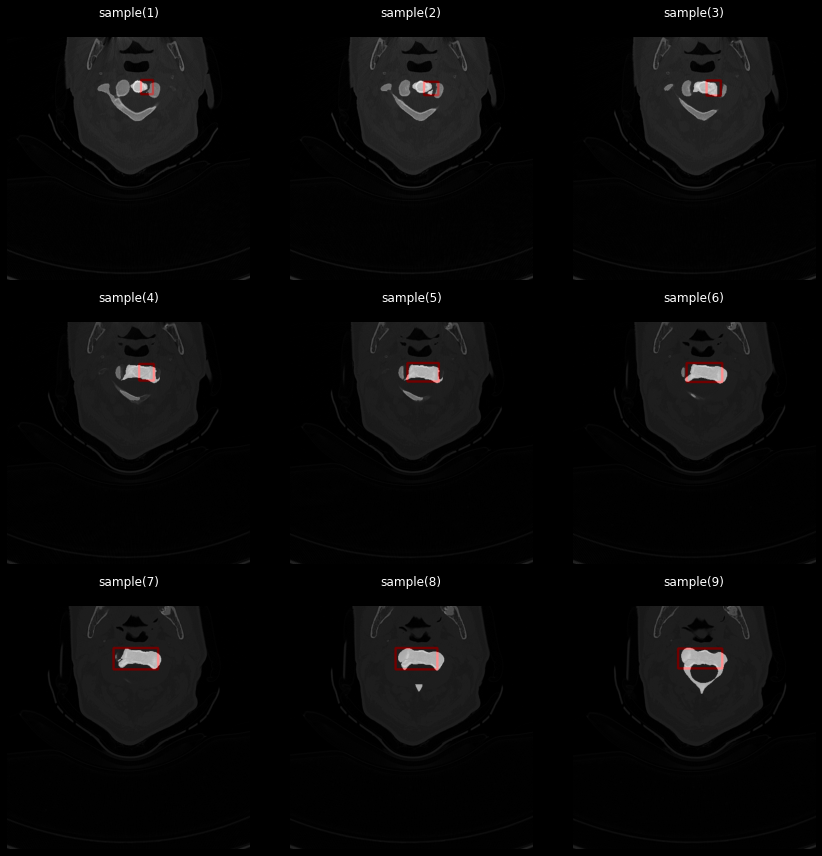

In [10]:
fig = plt.figure(figsize=(12,12))

for i, row in df_inter.iterrows():
    s_uid = row['StudyInstanceUID']
    s_num = row['slice_number']
    x_min = row['x_min']
    x_max = row['x_max']
    y_min = row['y_min']
    y_max = row['y_max']
    
    nii = nib.load(nii_dir + s_uid + '.nii')
    # (ref) discussion : Explaining Data and Submission in detail
    nii = nii.get_fdata()[:, ::-1, ::-1].transpose(2,1,0)
    nii = nii[int(s_num)]
    
    dicom = pydicom.read_file(dicom_train_dir + s_uid + f'/{s_num}.dcm')
    dicom = dicom.pixel_array
    dicom = (dicom - np.min(dicom)) / np.max(dicom)
    dicom = (dicom * 255).astype(np.uint8)
    dicom = cv2.cvtColor(dicom, cv2.COLOR_GRAY2RGB)
    cv2.rectangle(dicom, pt1=(x_min, y_min), pt2=(x_max, y_max), color=(255,0,0), thickness=3)
    if i <= 8:
        ax = fig.add_subplot(int(f'33{i+1}'))
        ax.imshow(nii, alpha=1, cmap='gray')
        ax.imshow(dicom, alpha=0.45)
        ax.set_title(f'sample({i+1})\n')
        ax.axis('off')
    else:
        break;
        
plt.tight_layout()
plt.show()

## Step 3. And.. Let's make Class

In [11]:
class DrawFracSample():
    def __init__(self):
        self.data_folder = '../input/rsna-2022-cervical-spine-fracture-detection/'
        self.nii_dir = self.data_folder + 'segmentations/'
        self.bbox_path = self.data_folder + 'train_bounding_boxes.csv'
        self.dicom_train_dir = self.data_folder + 'train_images/'
        
        self.get_frac_info()
        self.show_fractures()
        
    def get_frac_info(self):
        df_bbox = pd.read_csv(self.bbox_path)
        df_bbox['StudyInstanceUID'] = df_bbox['StudyInstanceUID'].astype('str')
        df_bbox['slice_number'] = df_bbox['slice_number'].astype('str')
        df_bbox['x_min'] = df_bbox['x'].astype('int64')
        df_bbox['y_min'] = df_bbox['y'].astype('int64')
        df_bbox['x_max'] = df_bbox['x_min'] + df_bbox['width'].astype('int64')
        df_bbox['y_max'] = df_bbox['y_min'] + df_bbox['height'].astype('int64')
        df_bbox.drop(['x','y','width','height'], axis=1, inplace=True)
        
        nii_paths = glob(self.nii_dir + '*.nii')
        nii_ids = [x.split('/')[-1][:-4] for x in nii_paths]
        isin_nii_ids = df_bbox['StudyInstanceUID'].apply(lambda x : x if x in nii_ids else None)
        self.df_inter = df_bbox.iloc[isin_nii_ids.dropna().index]
        self.df_inter.reset_index(drop=True, inplace=True)

    def show_fractures(self, alp=0.45):
        fig = plt.figure(figsize=(12,12))

        # 10% randomly selected from a df_inter
        df_sample = self.df_inter.sample(frac=0.1).reset_index(drop=True)
        for i, row in df_sample.iterrows():
            s_uid = row['StudyInstanceUID']
            s_num = row['slice_number']
            x_min = row['x_min']
            x_max = row['x_max']
            y_min = row['y_min']
            y_max = row['y_max']

            nii = nib.load(self.nii_dir + s_uid + '.nii')
            # (ref) discussion : Explaining Data and Submission in detail
            nii = nii.get_fdata()[:, ::-1, ::-1].transpose(2,1,0)
            nii = nii[int(s_num)]

            dicom = pydicom.read_file(self.dicom_train_dir + s_uid + f'/{s_num}.dcm')
            
            # we cannot load some of dicom file with this code. so we will use apply_voi_lut() for all.
            #dicom = dicom.pixel_array
            dicom = apply_voi_lut(dicom.pixel_array, dicom)
            dicom = (dicom - np.min(dicom)) / np.max(dicom)
            dicom = (dicom * 255).astype(np.uint8)
            dicom = cv2.cvtColor(dicom, cv2.COLOR_GRAY2RGB)
            cv2.rectangle(dicom, pt1=(x_min, y_min), pt2=(x_max, y_max), color=(255,0,0), thickness=3)
            if i+1 <= 9:
                ax = fig.add_subplot(int(f'33{i+1}'))
                ax.imshow(nii, alpha=1, cmap='gray')
                ax.imshow(dicom, alpha=alp)
                ax.set_title(f'sample({i+1})\n')
                ax.axis('off')
            else:
                break;
        plt.tight_layout()
        plt.show()

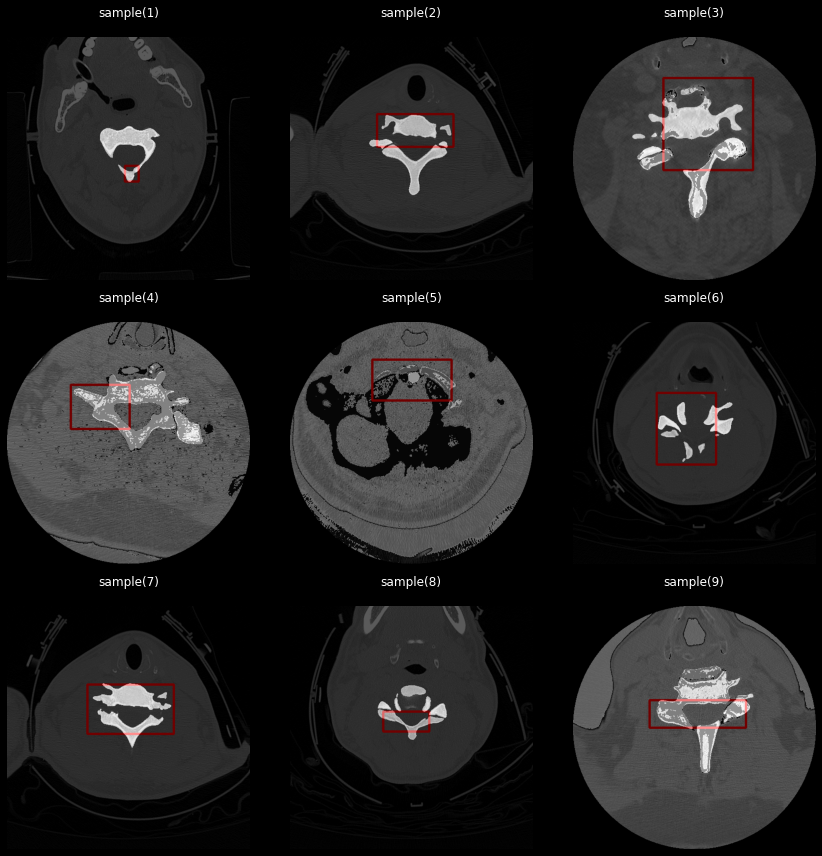

In [12]:
dfs = DrawFracSample()

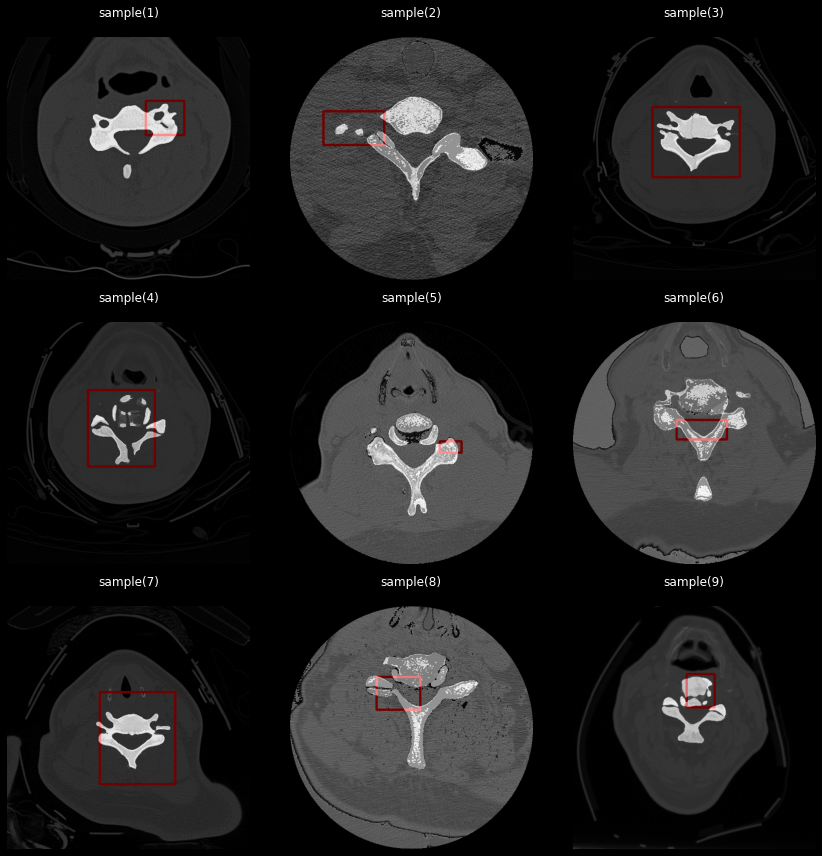

In [13]:
dfs = DrawFracSample()

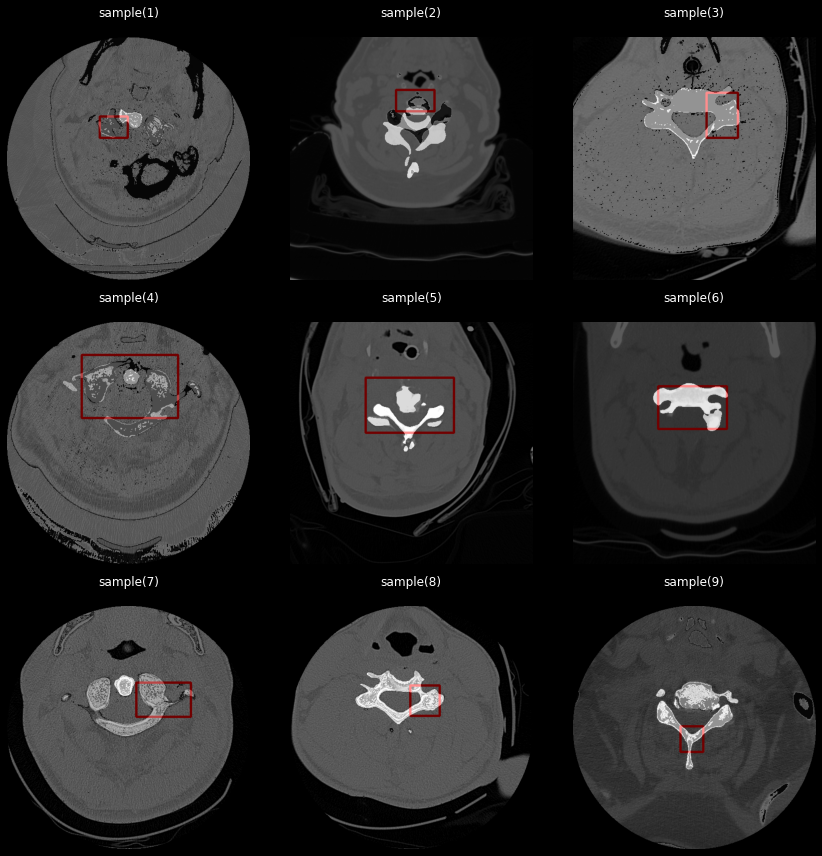

In [14]:
dfs = DrawFracSample()